In [16]:
# numerica import
import torch
import gpytorch

# vff import
from VFF.models import Matern12VFF

# basline GP import
from models.exactGP.ExactGP import GPModel

# data import
import pandas as pd

# plotting import
import matplotlib.pyplot as plt

# Variational Fourier Features Gaussian Process model demo

This notebook demo's the use of the VFF model class for 1D data on time series data of Moody's Seasoned AAA Corporate Bond Yield sourced from [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/series/DAAA)

In [17]:
# data processing
df = pd.read_csv('DAAA.csv') # load data
df['DATE'] = pd.to_datetime(df['DATE']) # convert to datetime
df['DAAA'] = pd.to_numeric(df['DAAA'], errors='coerce') # convert to numeric (if cannot convert to numeric convert to nan)
df.dropna(inplace = True) # drop nan

# load data into tensors# data
X = torch.linspace(0., 1., len(df), dtype=torch.float32) # date -> [0, 1] idx
y = torch.tensor(df['DAAA'].values, dtype=torch.float32)

In [18]:
# slice data - create missing chunks masks gor GP to interpolate
int_1 = torch.logical_and(X >= 0.0, X < 0.3) # 0.3 -> 0.4
int_2 = torch.logical_and(X >= 0.4, X < 0.7) # 0.7 -> 0.8
int_3 = torch.logical_and(X >= 0.8, X < 1.1) # 0.7 -> 0.8
data_mask = int_1 + int_2 + int_3

Text(0.5, 0.98, "Moody's Seasoned Aaa Corporate Bond Yield")

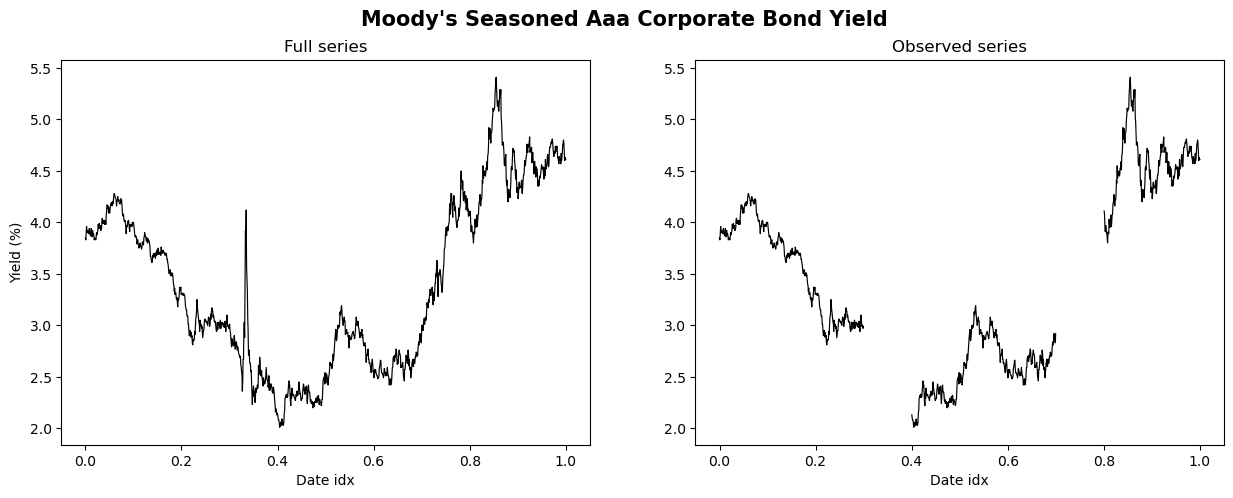

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot full series
ax1.plot(X, y, color = 'black', label = 'Series', alpha = 1., linewidth = 0.85)
ax1.set_title('Full series')
ax1.set_xlabel('Date idx')
ax1.set_ylabel('Yield (%)')

# plot partial series
for interval in [int_1, int_2, int_3]:
    plt.plot(X[interval], y[interval], color = 'black', alpha = 1., linewidth = 0.85)
ax2.set_title('Observed series')
ax2.set_xlabel('Date idx')

plt.suptitle("Moody's Seasoned Aaa Corporate Bond Yield", fontsize = 15, fontweight = 'bold')

In [21]:
# training data
X_train = X[data_mask]
y_train = y[data_mask]

In [22]:
# INITIALISE THE VFF MODEL

# define the model
vff_gp = Matern12VFF(X = X_train, y = y_train, nfrequencies = 25, alim = -0.8, blim = 1.2) # lims provide 'wiggle room'

# fit the model
model_trace = vff_gp.fit(niter = 1000, learningrate = 0.01, trace = True) # ~2 mins on CPU 

In [51]:
# INITIALISE THE BASELINE GP MODEL

# define the model
baseline_gp = GPModel(train_x = X_train, train_y = y_train, likelihood=gpytorch.likelihoods.GaussianLikelihood(), kernel = gpytorch.kernels.MaternKernel(nu = 1/2))

# fit the model
baseline_gp.parameter_learn(1000, 0.01)

   Iteration   |     Loss      |     Noise     |  Lengthscale  |  Outputscale  
      100      |     0.408     |     0.309     |     1.107     |     1.136     
      200      |    -0.045     |     0.117     |     1.414     |     1.391     
      300      |    -0.486     |     0.043     |     1.656     |     1.581     
      400      |    -0.861     |     0.016     |     1.834     |     1.611     
      500      |    -1.131     |     0.007     |     1.924     |     1.617     
      600      |    -1.254     |     0.003     |     1.929     |     1.664     
      700      |    -1.328     |     0.002     |     1.883     |     1.647     
      800      |    -1.308     |     0.001     |     1.767     |     1.641     
      900      |    -1.305     |     0.001     |     1.759     |     1.647     
     1000      |    -1.293     |     0.001     |     1.657     |     1.667     


In [52]:
# GET VFF GP POSTERIOR FOR TEST INPUTS

# test data
X_test = torch.linspace(-0, 1, 1000)

# get posterior predictive
posterior_predictive = vff_gp.posterior_predictive(X_test)

# posterior predictive mean
f_pred_mean = posterior_predictive.mean.detach().numpy()
upper, lower = posterior_predictive.confidence_region()

In [53]:
# MODEL COMPARISON

# test data
X_test = torch.linspace(-0, 1, 1000)

# vff model
vff_gp_posterior_predictive = vff_gp.posterior_predictive(X_test)
vff_gp_pred_mean = vff_gp_posterior_predictive.mean.detach().numpy()
vff_gp_upper, vff_gp_lower = vff_gp_posterior_predictive.confidence_region()

# Baseline GP model
baseline_gp_posterior_predictive = baseline_gp.predict(X_test)
baseline_gp_pred_mean = baseline_gp_posterior_predictive.mean.detach().numpy()
baseline_gp_upper, baseline_gp_lower = baseline_gp_posterior_predictive.confidence_region()

In [54]:
def plot_observed_data(axis):
    """ refactored helper function to plot observed data. axis is a matplotlib axis object return from subplots()"""
    for interval in [int_1, int_2, int_3]:
        axis.plot(X[interval], y[interval], color = 'black', alpha = 1., linewidth = 0.85)
    return None

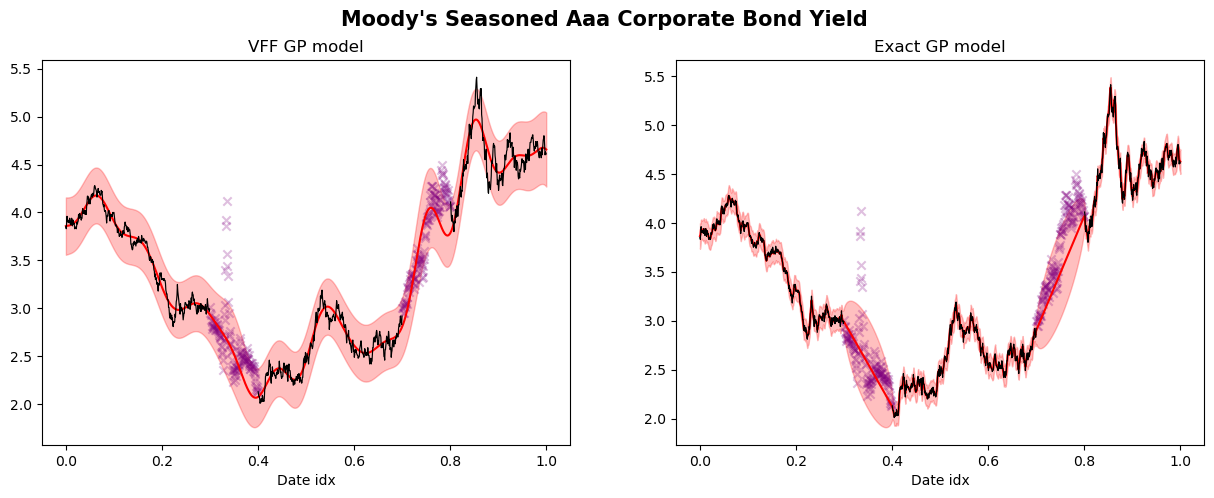

In [55]:
# PLOT VFF GP POSTERIOR INTERPOLATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# vff model
ax1.plot(X_test, vff_gp_pred_mean, color = 'red', label = 'Posterior predictive mean')
ax1.fill_between(X_test, vff_gp_upper.detach().numpy(), vff_gp_lower.detach().numpy(), alpha = 0.25, color = 'red', label = '95% confidence region')
# plot the missing datq
ax1.scatter(X[~data_mask], y[~data_mask], marker = 'x', alpha = 0.25, color = 'purple', label = 'Missing data')
plot_observed_data(ax1)
ax1.set_title('VFF GP model')
ax1.set_xlabel('Date idx')

# baseline GP model
ax2.plot(X_test, baseline_gp_pred_mean, color = 'red', label = 'Posterior predictive mean')
ax2.fill_between(X_test, baseline_gp_upper.detach().numpy(), baseline_gp_lower.detach().numpy(), alpha = 0.25, color = 'red', label = '95% confidence region')
# plot the missing datq
ax2.scatter(X[~data_mask], y[~data_mask], marker = 'x', alpha = 0.25, color = 'purple', label = 'Missing data')
plot_observed_data(ax2)
ax2.set_title('Exact GP model')
ax2.set_xlabel('Date idx')

plt.suptitle("Moody's Seasoned Aaa Corporate Bond Yield", fontsize = 15, fontweight = 'bold');